In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform
from REStats.models import fit_weibull

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

In [2]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

In [3]:
wt = load_SCADA(2020)

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

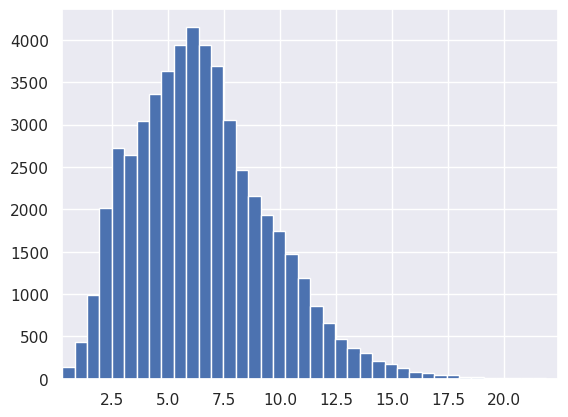

In [4]:
fig, ax = plt.subplots()
ax.set_xmargin(0)

d = ax.hist(wt["Wind speed"], bins=40)

In [5]:
wt_1m = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")]

ws = wt_1m[["Wind speed"]]

# Resample to hourly

vh = ws.resample("H").mean()

In [6]:
vh.isnull().sum() == 0, len(vh)

(Wind speed    True
 dtype: bool,
 744)

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [7]:
idata_wb = fit_weibull(vh)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Sampling: [y]


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

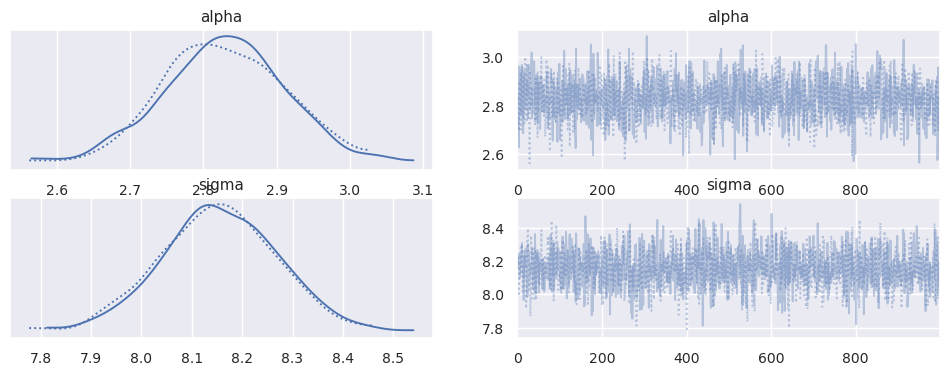

In [8]:
az.plot_trace(idata_wb)

In [9]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1818.17    16.65
p_loo        2.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      744  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='y / y'>

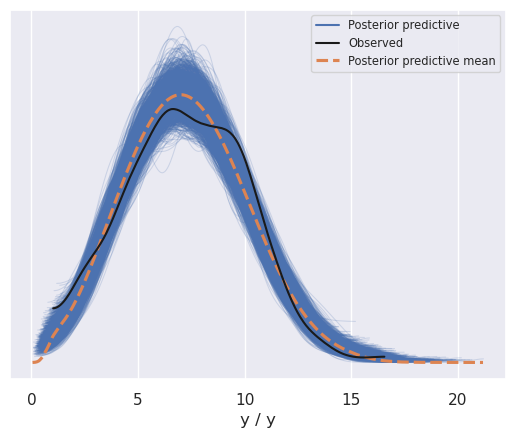

In [10]:
az.plot_ppc(idata_wb)

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [11]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.sigma.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7855792041742928


## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

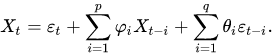

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

In [12]:
v_tf, hr_stats = transform(vh, m, field="Wind speed")

v_tf.head()

,Wind speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2020-01-01 00:00:00,3.867503,2.893832,3.867503,0,-1.313123
2020-01-01 01:00:00,5.663008,3.904615,5.663008,1,-0.555103
2020-01-01 02:00:00,4.896892,3.483271,4.896892,2,-0.968220
2020-01-01 03:00:00,5.320999,3.718135,5.320999,3,-0.868190
2020-01-01 04:00:00,4.438020,3.224174,4.438020,4,-1.402106


Text(0.5, 0, 'std')

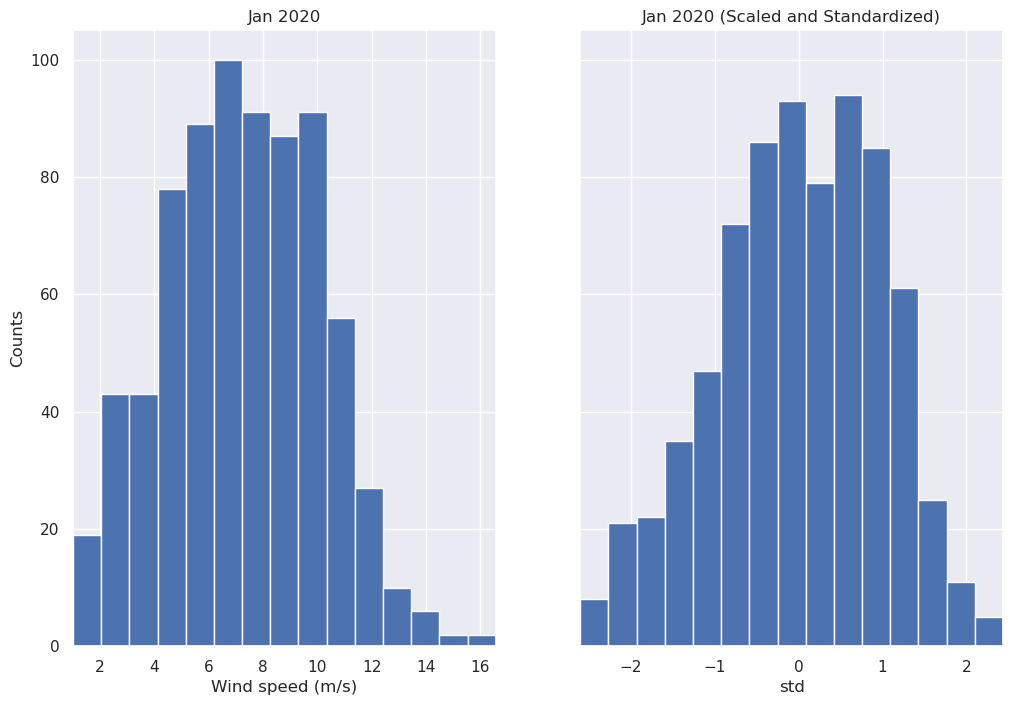

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(v_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(v_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

In [14]:
arma_mod = ARIMA(v_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  744
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -223.622
Date:                Thu, 09 Mar 2023   AIC                            457.244
Time:                        02:03:38   BIC                            480.304
Sample:                    01-01-2020   HQIC                           466.133
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4084      0.240      1.702      0.089      -0.062       0.879
ar.L2          0.5138      0.223      2.299      0.021       0.076       0.952
ma.L1          0.5409      0.239      2.265      0.0

In [15]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2020-01-01 00:00:00,0.000000,0.989454,-1.939294,1.939294
2020-01-01 01:00:00,-1.238963,0.327811,-1.881460,-0.596465
2020-01-01 02:00:00,-0.523413,0.327811,-1.165911,0.119084
2020-01-01 03:00:00,-0.974526,0.326836,-1.615114,-0.333938
2020-01-01 04:00:00,-0.758530,0.326554,-1.398565,-0.118495
...,...,...,...,...
2020-01-31 19:00:00,0.688521,0.326314,0.048956,1.328085
2020-01-31 20:00:00,0.621995,0.326314,-0.017570,1.261559
2020-01-31 21:00:00,0.594465,0.326314,-0.045099,1.234030


Reverse the transformations for error calculations and plotting.

In [16]:
inv_pred = inv_transform(pred, m, hr_stats)
rmse = mean_squared_error(v_tf.v, inv_pred["mean"], squared=False)
print("RMSE:", rmse)

RMSE: 0.8954627744920747


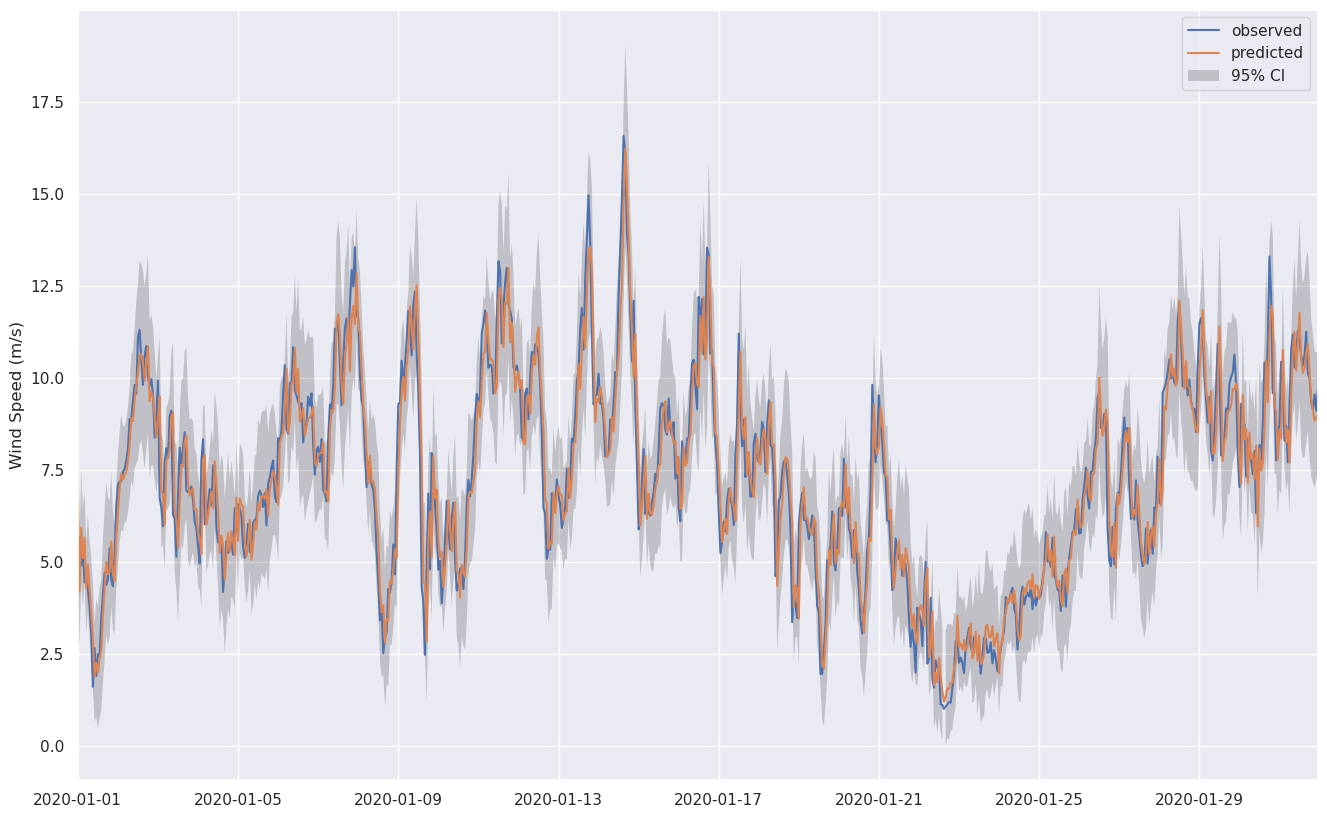

In [17]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(v_tf.index, v_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()


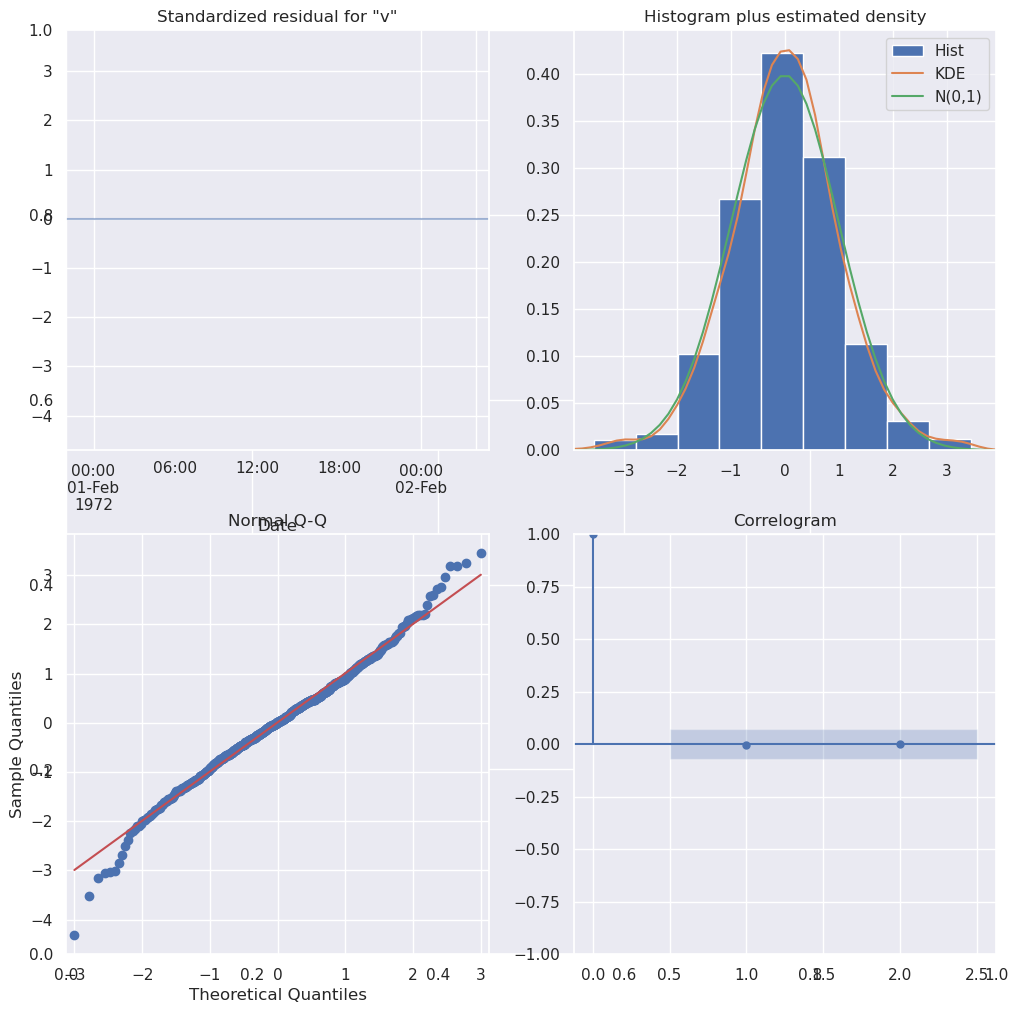

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

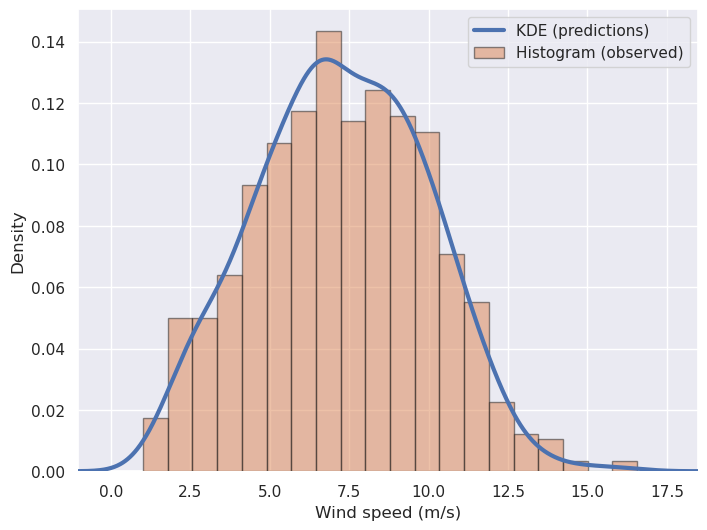

In [19]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    v_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

## Forecast

In [20]:
wt_test = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")].copy()

In [21]:
ws_test = wt_test[["Wind speed"]].resample("H").mean()
assert ws_test["Wind speed"].isnull().sum() == 0 # sanity check

v_tf_test, hr_stats = transform(ws_test, m, field="Wind speed")
v_tf_test.head()

,Wind speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2020-02-01 00:00:00,9.675224,5.947231,9.675224,0,0.155357
2020-02-01 01:00:00,9.348447,5.788856,9.348447,1,0.045339
2020-02-01 02:00:00,8.373743,5.309168,8.373743,2,-0.228399
2020-02-01 03:00:00,9.559914,5.891478,9.559914,3,0.055063
2020-02-01 04:00:00,10.035535,6.120535,10.035535,4,0.095104


<Axes: xlabel='Date'>

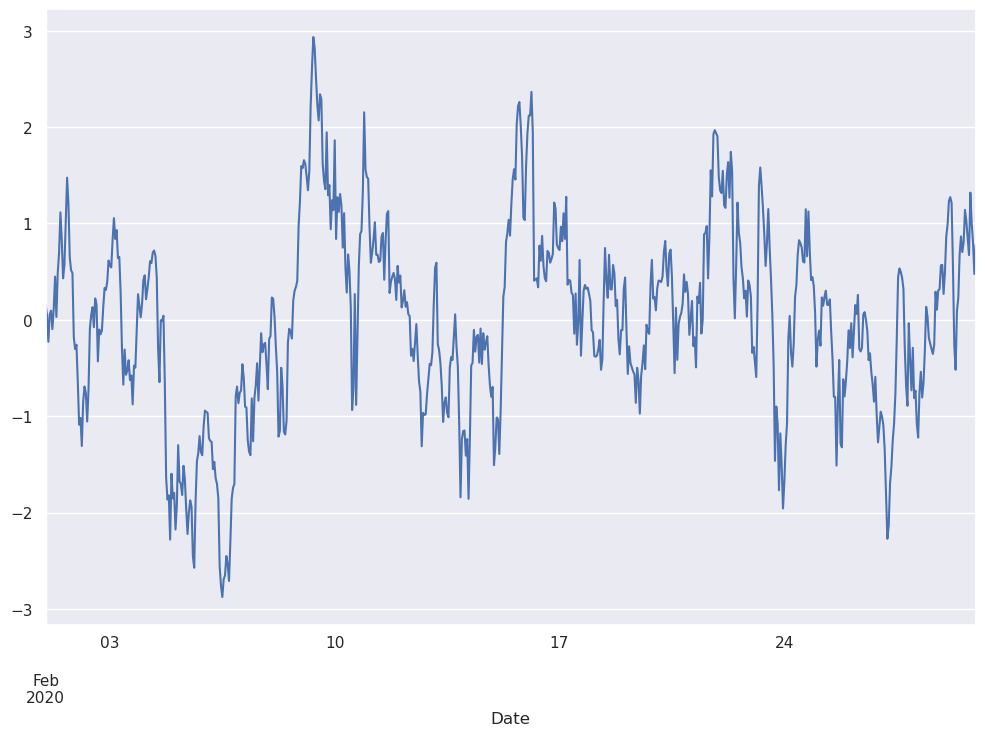

In [22]:
v_tf_test.v_scaled_std.plot(figsize=(12, 8))

In [23]:
nforecasts = 1
forecasts = {}

# Save initial forecast
# forecasts[v_tf.index[-1]] = arma_res.forecast(steps=nforecasts)

v_test = v_tf_test.v_scaled_std

# Step through the rest of the sample
for t in range(len(v_tf_test)):
    # Update the results by appending the next observation
    updated_endog = v_test.iloc[t:t+1]
    arma_res = arma_res.append(updated_endog, refit=False)

    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = arma_res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

In [24]:
inv_forecasts = inv_transform(forecasts, m, hr_stats)
inv_forecasts.iloc[:5, :5]

,2020-02-01 00:00:00,2020-02-01 01:00:00,2020-02-01 02:00:00,2020-02-01 03:00:00,2020-02-01 04:00:00
2020-02-01 01:00:00,9.616318,NaN,NaN,NaN,NaN
2020-02-01 02:00:00,NaN,9.590386,NaN,NaN,NaN
2020-02-01 03:00:00,NaN,NaN,8.514137,NaN,NaN
2020-02-01 04:00:00,NaN,NaN,NaN,10.064124,NaN
2020-02-01 05:00:00,NaN,NaN,NaN,NaN,9.616019


In [25]:
forecast_errors = inv_forecasts.apply(lambda column: v_tf_test.v - column).reindex(inv_forecasts.index)
forecast_errors.iloc[:5, :5]

,2020-02-01 00:00:00,2020-02-01 01:00:00,2020-02-01 02:00:00,2020-02-01 03:00:00,2020-02-01 04:00:00
2020-02-01 01:00:00,-0.267871,NaN,NaN,NaN,NaN
2020-02-01 02:00:00,NaN,-1.216644,NaN,NaN,NaN
2020-02-01 03:00:00,NaN,NaN,1.045777,NaN,NaN
2020-02-01 04:00:00,NaN,NaN,NaN,-0.028589,NaN
2020-02-01 05:00:00,NaN,NaN,NaN,NaN,-0.489797


In [26]:
def flatten(column):
    return column.dropna().reset_index(drop=True)

In [27]:
inv_forecasts_flattened = inv_forecasts.apply(flatten)

In [28]:
flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')
flattened.iloc[:, :5]

,2020-02-01 00:00:00,2020-02-01 01:00:00,2020-02-01 02:00:00,2020-02-01 03:00:00,2020-02-01 04:00:00
horizon,,,,,
1,-0.267871,-1.216644,1.045777,-0.028589,-0.489797


In [29]:
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

horizon
1    1.213184
dtype: float64


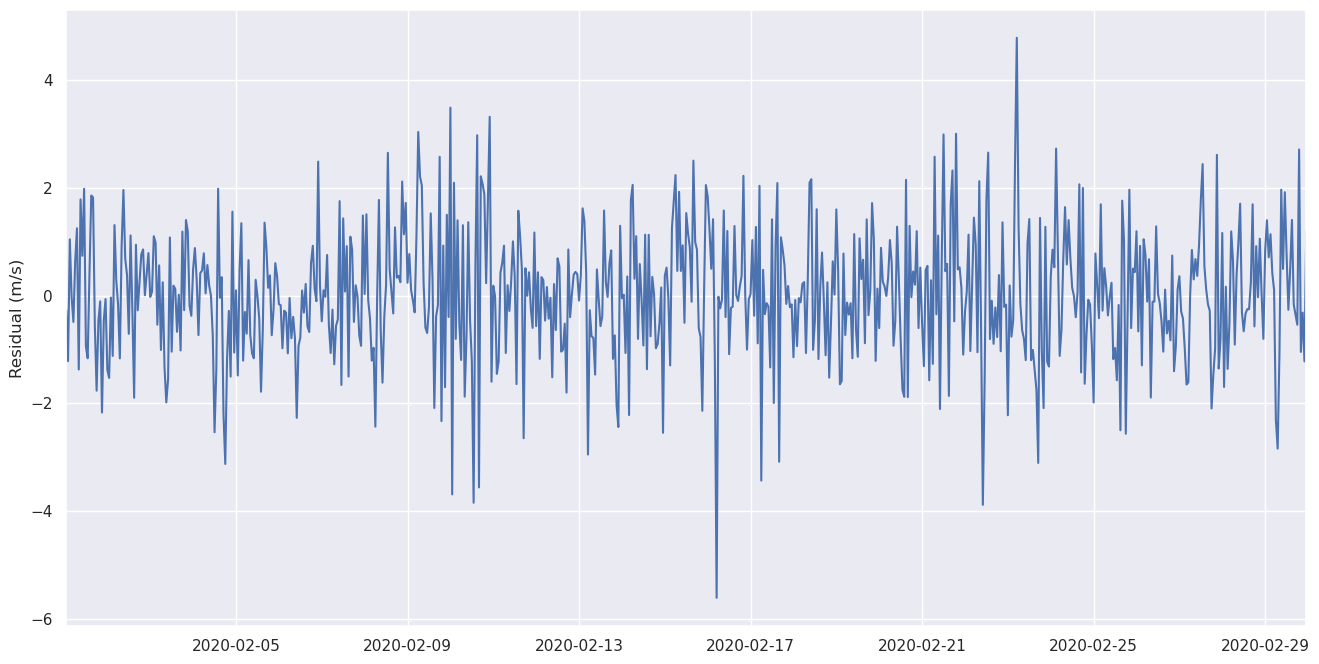

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)

ax.plot(inv_forecasts.index, flattened.iloc[0, :])

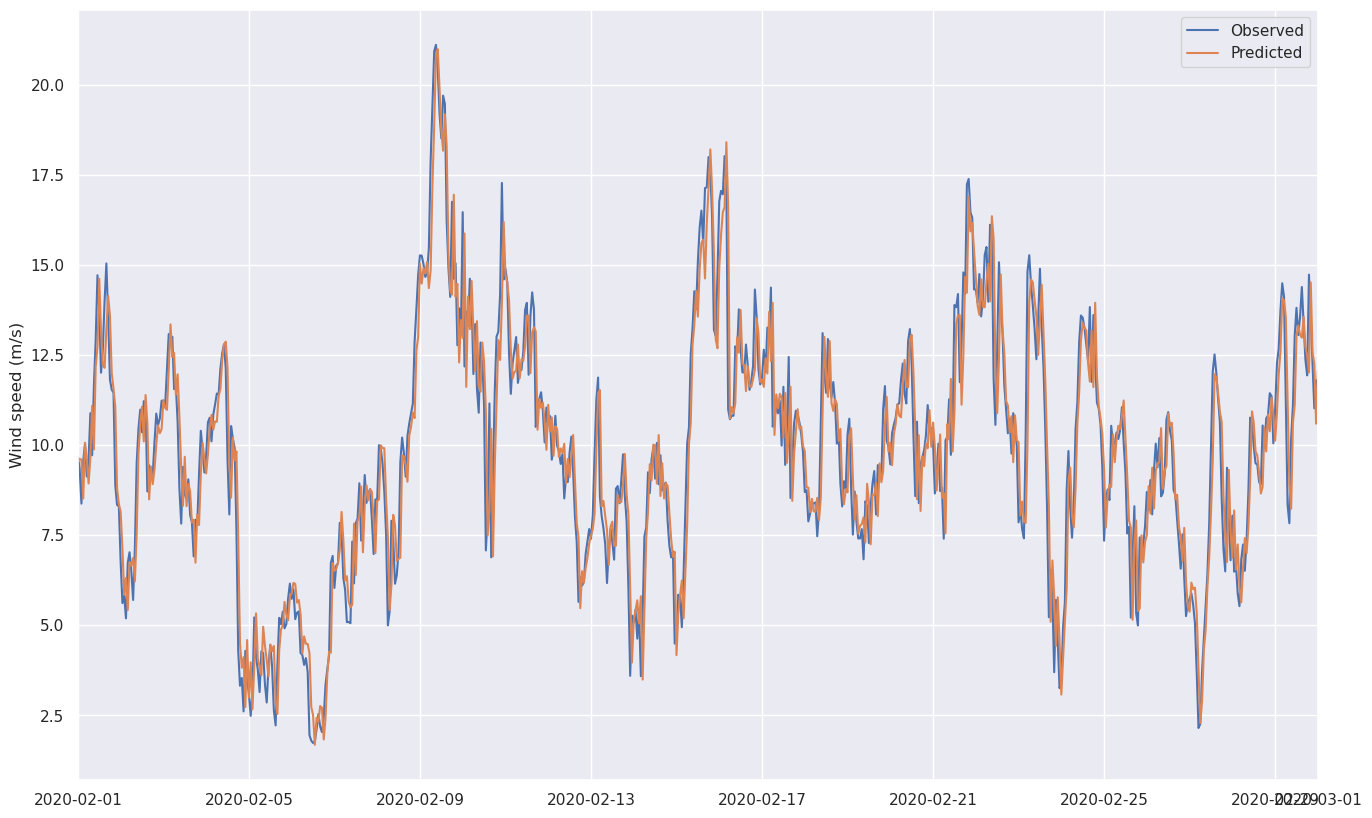

In [31]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_tf_test.index, v_tf_test.v, label="Observed")
ax.plot(inv_forecasts.index, inv_forecasts_flattened.iloc[0, :], label="Predicted")

ax.legend()